# Star Trek Deep Space Nine Language Modelling

## Loading pre-trained model word2vec

Let's start with a famous example using the Google Word2Vec embeddings.
Source: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

In [401]:
from gensim.models import KeyedVectors
filename = 'GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [416]:
# calculate: (king - man) + woman = ?
result = model.most_similar(positive=['woman','king'], negative=['man'], topn=1)
print(result)

[('queen', 0.7118192911148071)]


In [417]:
result = model.most_similar(positive=['woman','husband'], negative=['man'], topn=1)
print(result)

[('mother', 0.712462842464447)]


In [418]:
result = model.most_similar(positive=['man','wife'], negative=['woman'], topn=1)
print(result)

[('son', 0.6474398970603943)]


In [419]:
result = model.most_similar(positive=['obama', 'woman'], negative=['man'], topn=1)
print(result)

[('hillary', 0.653923749923706)]


In [423]:
result = model.most_similar(positive=['obama', 'woman'], negative=['man'], topn=3)
print(result)

[('hillary', 0.653923749923706), ('palin', 0.6398327946662903), ('mccain', 0.6027775406837463)]


## Making our own embedding with gensim

In [233]:
from gensim.models import Word2Vec
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from nltk.corpus import stopwords
stopset = set(stopwords.words('english'))
from nltk.tokenize import SpaceTokenizer, RegexpTokenizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import re
import warnings	
warnings.filterwarnings('ignore')

### On a small fake example

In [145]:
sentences = ['1skldj orange juice alksjd ',
             '2laksjd apple juice ,sand ',
             '3aksldm Orange fruit akjdsn ',
             '4alsdj Apple fruit aslkdj ',
             '5aksd abc abc laskdj ',
             '6aslkdj capital Paris alsDK ',
             '7lkdsj Brussels capital asdkljf ',
             '8xzkc Brussels Belgium asdl ',
             '9wope France Paris laskd ',
             '0asdkf Paris capital alsfk ',
             'askd Brussels capital 0asld ',
             'mxznc Brussels Belgium 9wopuer ',
             'mn Paris France 8poiu ',
             'mnv Paris capital 8poiuv ',
             'mnvf capital paris 8oiuv ',
             'nbv abc abc 7khjg ',
             'kkoi orange juice 6ojihjbvh ',
             'bhvkh apple juice 5oijhg ',
             'drfgh Orange fruit 4lkjh ',
             'fgh Apple fruit 3cvb ',
             'mnb abc abc 2pok ']
sentences = sentences + [w.split()[0][::-1] + ' ' + 
                         w.split()[2]       + ' ' + 
                         w.split()[2]       + ' ' + 
                         w.split()[3][::-1]
                         for w in sentences ]

In [146]:
vocab = ['orange',
         'juice',
         'apple',
         'fruit',
         'paris',
         'capital',
         'brussels',
         'belgium',
         'france']

In [147]:
words_in_sentences = []
tokenizer = RegexpTokenizer(r'\w+')
for sentence in sentences:
    words = tokenizer.tokenize(sentence.lower())
    words = [word for word in words if not word in stopset]
    words_in_sentences.append(words)

In [148]:
model = Word2Vec(words_in_sentences, size=3, window=1, min_count=2, iter=5000)

In [149]:
for v in vocab:
    print(model[v], v)

[ 1.3994391  -0.8114743  -0.15740167] orange
[ 1.828701   -1.39304     0.18959491] juice
[ 1.3898005  -0.77116525 -0.1940518 ] apple
[ 2.1175394  -0.22157069 -0.8288723 ] fruit
[1.0778681  0.69939953 0.39544147] paris
[0.74281716 0.22682156 1.3208117 ] capital
[0.81119823 0.00313335 1.6595428 ] brussels
[1.0515277  0.04980896 2.2077684 ] belgium
[ 1.482009    0.7824423  -0.14784157] france


In [150]:
for v in vocab:
    print(v, model.most_similar(positive=v, topn=2))

orange [('apple', 0.9995236396789551), ('juice', 0.976169228553772)]
juice [('orange', 0.976169228553772), ('apple', 0.9690120816230774)]
apple [('orange', 0.9995236396789551), ('juice', 0.9690120816230774)]
fruit [('apple', 0.8951129913330078), ('orange', 0.8815546631813049)]
paris [('france', 0.9223769307136536), ('abc', 0.8674753904342651)]
capital [('belgium', 0.989519476890564), ('brussels', 0.9875888824462891)]
brussels [('belgium', 0.999774158000946), ('capital', 0.9875888824462891)]
belgium [('brussels', 0.9997740983963013), ('capital', 0.9895193576812744)]
france [('paris', 0.9223769903182983), ('fruit', 0.8032046556472778)]


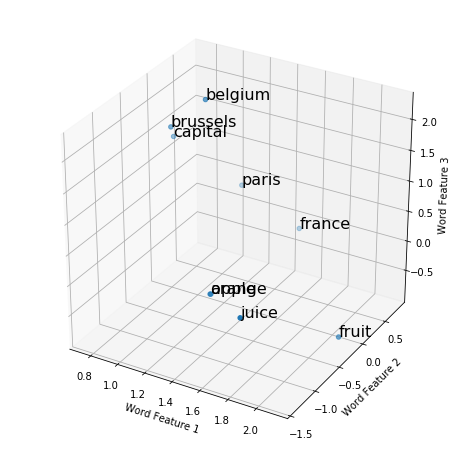

In [151]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

xs = []
ys = []
zs = []
labels = []

for v in vocab:
    labels.append(v)
    xs.append(model[v][0])
    ys.append(model[v][1])
    zs.append(model[v][2])

ax.scatter(xs, ys, zs)

for label, x, y, z in zip(labels, xs, ys, zs):
    
    ax.text(x, y, z, label, size=16)

ax.set_xlabel('Word Feature 1')
ax.set_ylabel('Word Feature 2')
ax.set_zlabel('Word Feature 3')

plt.show()

### On Star Trek Deep Space Nine scripts

In [204]:
PATH = 'ScriptsDS9/'
trn_files = !ls {PATH}
trn_files[:10] # as a test

['402.txt',
 '403.txt',
 '404.txt',
 '405.txt',
 '406.txt',
 '407.txt',
 '408.txt',
 '409.txt',
 '410.txt',
 '411.txt']

In [206]:
len(trn_files) # Total number of scripts

173

In [207]:
# concat all scripts
input_all = ''
counter = 0
for f in trn_files:
    try:
        inputstring = open(p+f, 'r').read().lower()
        input_all += inputstring
    except:
        print(f, 'Error')
        counter += 1
print(counter, 'files not read')

414.txt Error
420.txt Error
459.txt Error
464.txt Error
468.txt Error
470.txt Error
472.txt Error
7 files not read


In [208]:
# A number of scripts did not load, due to char comversion issue
# Since the number is small, we will ignore

In [212]:
# replace newline, tab and more than one space with one space
input_all = re.sub("\t",' ',input_all)
input_all = re.sub("\n",' ',input_all)
input_all = re.sub(' +',' ',input_all)

In [213]:
sentences = sent_tokenize(input_all)

In [214]:
len(sentences)

173646

In [313]:
# print a sample just to check
for i in range(15):
    print("---")
    print(sentences[50+i])

---
sisko's quarters (optical) destroyed... an explosion has ripped a hole in the floor... fire and smoke is streaking up through it... outside the window we can see evidence that the battle with the borg ship is continuing... sisko enters, sees his wife buried in rubble... he urgently pulls things away to get to her... he uncovers the upper part of her body... beside her is an unconscious nine year old boy... sisko (calm, controlled) it's gonna be okay... i'll get you out of there... you're gonna be okay... but he can't lift the wreckage that has crushed her lower half... his calm demeanor is betrayed by... deep space: "emissary" rev.
---
final 08/31/92 - teaser 6.
---
11 his hands desperately trying to lift heavy debris... 12 resume as he ignores the pain... but fails to make any headway, so he returns to the front and tries to pull the boy free... he's small enough to be eased out... he moves slightly, barely conscious, but not hurt critically... sisko okay, jake... we'll just get y

In [294]:
words_in_sentences = []
tokenizer = RegexpTokenizer(r'\w+')
for sentence in sentences:
    words = tokenizer.tokenize(sentence)
    words = [word for word in words if not word in stopset]
    words_in_sentences.append(words)

In [295]:
# print a sample just to check
for s in words_in_sentences[100:110]:
    print(s)

['space', 'ds9', 'optical', 'establishing']
['angle', 'see', 'enterprise', 'ships', 'docked']
['sisko', 'v']
['commence', 'station', 'log', 'deep', 'space', 'nine', 'commander', 'benjamin', 'sisko', 'stardate', 'xxxxx', 'x']
['request', 'bajoran', 'provisional', 'government', 'starfleet', 'agreed', 'establish', 'federation', 'presence', 'system', 'following', 'withdrawal', 'cardassian', 'occupational', 'forces']
['23', 'int']
['airlock', 'close', 'miles', 'brien', 'face', 'straining', 'physical', 'exertion', 'sweating', 'pulling', 'back', 'find', 'working', 'inside', 'open', 'panel', 'manually', 'working', 'levers', 'gears', 'starfleet', 'technology', 'means', 'struggles', 'airlock', 'slowly', 'opens', 'reveal', 'sisko', 'jake', 'standing', 'enter', 'brien', 'sorry', 'commander', 'interlock', 'servos', 'airlock', 'stripped', 'cardassians', 'sticks', 'hand', 'shake', 'realizes', 'covered', 'sludge', 'panel', 'pulls', 'back', 'brien', 'miles', 'brien', 'chief', 'operations', 'officer', '

In [312]:
# train model
model = Word2Vec(words_in_sentences, min_count=5,iter=500)

In [316]:
# save model
model.save('model.bin')
# load model
model = Word2Vec.load('model.bin')

In [317]:
# print a sample just to check
words = list(model.wv.vocab)
words[0:10]

['star',
 'trek',
 'deep',
 'space',
 'nine',
 'emissary',
 '40511',
 'teleplay',
 'michael',
 'piller']

In [318]:
# access vector for one word
print(model['klingon'])

[-0.578674   -1.5869062   2.7716231   3.1494613  -0.33363378  0.1273799
 -0.56963956 -4.287238    2.4331717  -0.48700303 -0.92714226  0.31471205
 -2.7141378  -0.37631008  1.9103869   1.2952993  -1.4651934  -0.3952099
  0.936955   -3.564264    0.73916143 -3.8995132   1.6098027  -0.35335854
 -1.2801449  -0.40430373 -2.377531    1.3860694  -1.9899653   1.4137101
  0.19993418  1.1880264   0.7347913   0.45919052 -2.3184881  -0.4326823
  0.7574526  -2.1952722  -4.4444065   0.2258203  -0.6847442   0.1593145
 -1.3921783  -3.5925744   1.0375044   4.194283   -1.397945   -3.1209722
  3.5359411   4.864412    2.2110858  -4.059782    2.969405    4.7693996
  2.8650262  -3.3703249  -1.585154    0.46853825  0.65022355 -1.3760531
 -2.23315     3.2354546   3.5395255  -2.5699744   2.358535   -1.727227
 -0.14223641  2.3258467  -0.13559628 -3.5556266  -0.52207124 -1.1375866
  3.6268191   0.47909507 -0.2070838  -5.5913286  -0.3040305  -0.99443287
 -1.3635714  -0.09242846 -1.0256983   2.3576775   2.3000665   

In [319]:
result = model.most_similar(positive=['klingon'], topn=1)
print(result)

[('romulan', 0.5651997923851013)]


In [387]:
def display_closestwords_tsnescatterplot(model, word, ax, title):
    
    arr = np.empty((0,100), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word, topn=5)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    ax.scatter(x_coords, y_coords)
    ax.set_title(title, size=20)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', size=16)
    plt.xlim(x_coords.min()-100, x_coords.max()+100)
    plt.ylim(y_coords.min()-100, y_coords.max()+100)
    
    #plt.show()

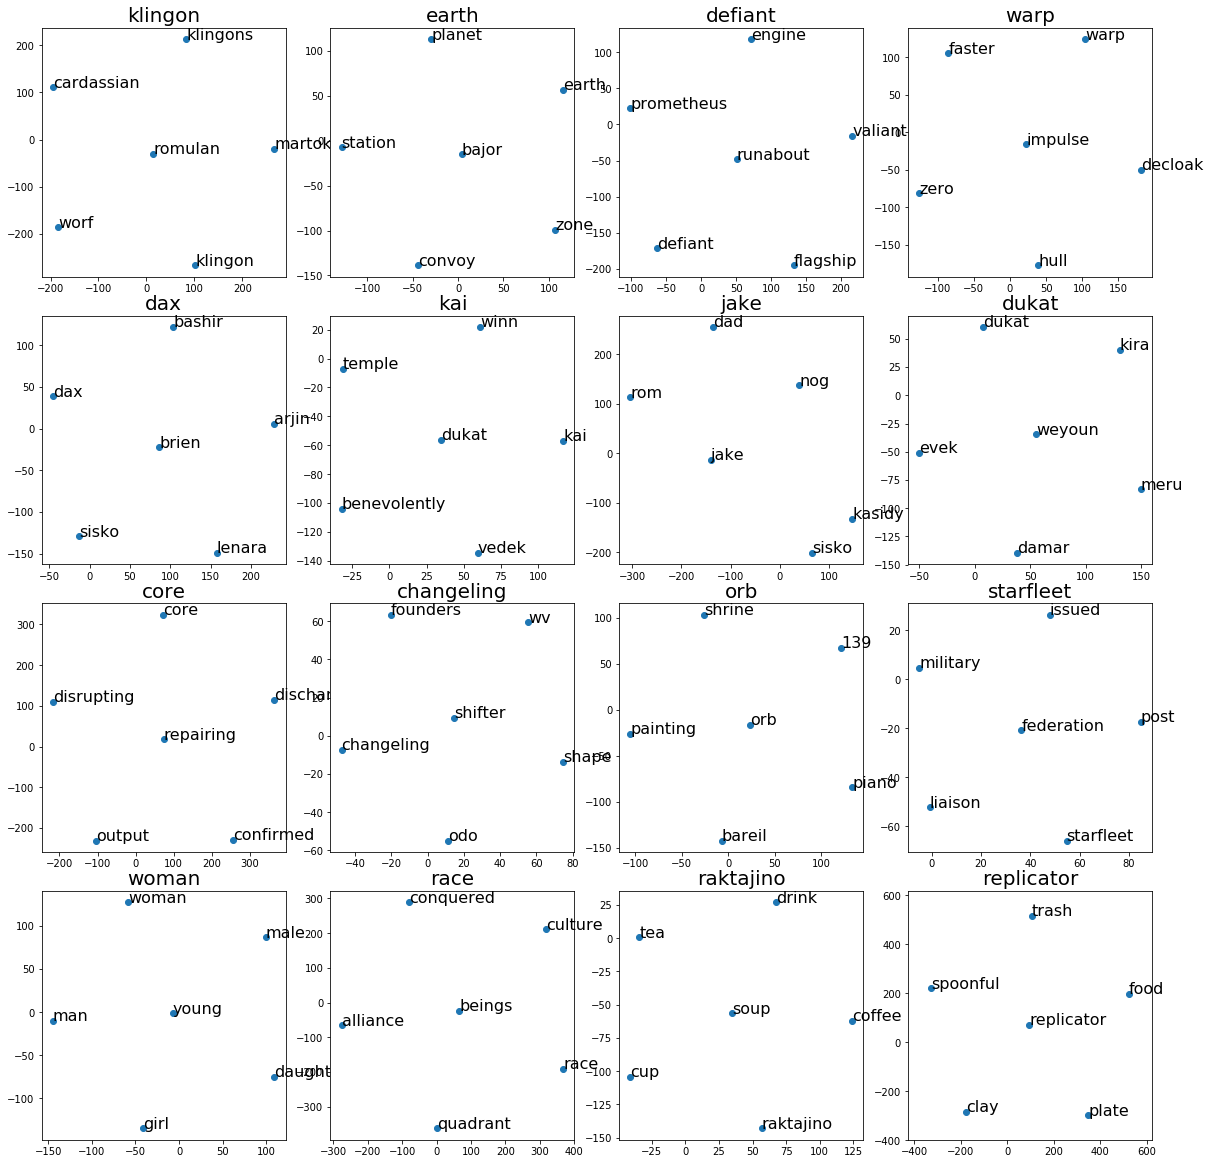

In [398]:
test = ['klingon', 'earth', 'defiant', 'warp',
        'dax', 'kai', 'jake', 'dukat',
        'core', 'changeling', 'orb', 'starfleet',
        'woman', 'race', 'raktajino', 'replicator']
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for i,ax in enumerate(axes.flat):
    ax = display_closestwords_tsnescatterplot(model, test[i], ax=ax, title=test[i])
plt.tight_layout(pad=0.1)

In [394]:
model.most_similar(positive=['kira','man'], negative=['woman'], topn=1)

[('sisko', 0.5769710540771484)]

In [395]:
model.most_similar(positive=['sisko','woman'], negative=['man'], topn=1)

[('kira', 0.6678581237792969)]

In [ ]:
# Major Kira and Commander Sisko